In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 34.0 MB/s eta 0:00:00


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# After running the language classifier, we can read the output and call the sentiment analysis pipeline.

In [4]:
from datetime import timedelta
import glob
from google.colab import drive, runtime 
import numpy as np
from os.path import isfile, basename
import pandas as pd
from transformers import pipeline
import time

In [5]:
# Mounts the Google Drive so we can access the CSV files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Reads all the new CSV files
fpaths = glob.glob("gdrive/My Drive/DW - Climate Protests/11.control_language_detect/*.csv")

In [7]:
# Reads each csv file and concatenates
df = pd.concat([ pd.read_csv(fpath) for fpath in fpaths]).reset_index()

In [8]:
# Keep only those that are in English
df = df[df.lang_label == 'en'].reset_index(drop=True)

<Axes: >

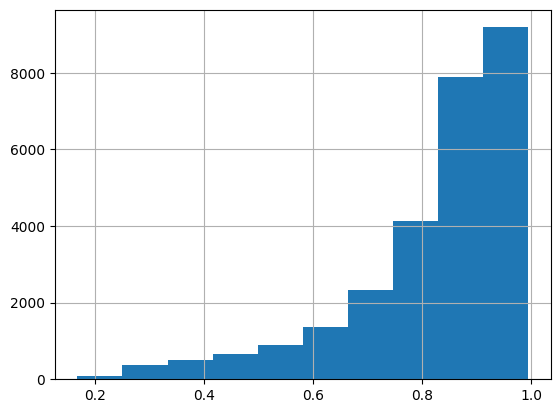

In [9]:
# How certain are we of the language classification?
df.lang_score.hist()

In [10]:
# Now we can apply another pre-trainer classifier to the remaining tweets, splitting them into "positive" and "negative".
classifier = pipeline(task="sentiment-analysis", model="siebert/sentiment-roberta-large-english")

In [11]:
# Functon that runs it through all tweets and saves the answer back to an array
def classify_sentiment(data, classifier):

  result = classifier(data.raw_content.tolist())
  result = pd.DataFrame(result)
  result = result.rename(columns={"label":"sentiment_label", "sentiment_score":"lang_score"})

  return pd.concat([data.reset_index(drop=True), result.reset_index(drop=True)], axis=1)

In [12]:
# We will split the dataframe in smaller chunks 
# so we don't lose all progress if anything goes wrong
dfs_split = np.array_split(df, 100)

In [ ]:
for index, chunk in enumerate(dfs_split):

  fname = f'gdrive/My Drive/DW - Climate Protests/12.control_sentiment_analysis/chunk-{index}.csv'

  if isfile(fname):
    continue

  start = time.time()
  
  result = classify_sentiment(chunk, classifier=classifier)
  result.to_csv(fname)

  end = time.time()
  print(f'Chunk {index} processing time:', str(timedelta(seconds=end-start)))

Chunk 0 processing time: 0:00:41.479624
Chunk 1 processing time: 0:00:41.089030
Chunk 2 processing time: 0:00:40.913403
Chunk 3 processing time: 0:00:42.523797
Chunk 4 processing time: 0:00:44.804376
Chunk 5 processing time: 0:00:44.690973
Chunk 6 processing time: 0:00:39.204573
Chunk 7 processing time: 0:00:37.256889
Chunk 8 processing time: 0:00:36.178323
Chunk 9 processing time: 0:00:38.989022
Chunk 10 processing time: 0:00:44.495983
Chunk 11 processing time: 0:00:43.910975
Chunk 12 processing time: 0:00:44.588412
Chunk 13 processing time: 0:00:40.081640
Chunk 14 processing time: 0:00:39.692461
Chunk 15 processing time: 0:00:36.217411
Chunk 16 processing time: 0:00:41.212938
Chunk 17 processing time: 0:00:44.684089
Chunk 18 processing time: 0:00:41.552739
Chunk 19 processing time: 0:00:40.008186
Chunk 20 processing time: 0:00:40.536227
Chunk 21 processing time: 0:00:38.909321
Chunk 22 processing time: 0:00:43.395641
Chunk 23 processing time: 0:00:41.530213
Chunk 24 processing time: 

In [ ]:
runtime.unassign()
